In [2]:
# Making sure the code is compatible with all Python versions and on different devices 
from __future__ import division, print_function, unicode_literals

# Loading necessary packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets 
from sklearn import linear_model 

# Loading the dataset
# Source - https://github.com/upalr/Python-camp/wiki/1.-Importing-data-from-the-Internet
from urllib.request import urlretrieve
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
urlretrieve(url, 'wdbc.csv')
# Adding column names using the data names appendix
wdbc_names = ['ID', 'Diagnosis', 'Mean Radius', 'Mean Texture', 'Mean Perimeter', 'Mean Area', 'Mean Smoothness', 
              'Mean Compactness', 'Mean Concavity', 'Mean Concave Points', 'Mean Symmetry', 'Mean Fractal Dimension', 
              'Radius SE', 'Texture SE', 'Perimeter SE', 'Area SE', 'Smoothness SE', 'Compactness SE', 'Concavity SE', 
              'Concave Points SE', 'Symmetry SE', 'Fractal Dimension SE', 'Worst Radius', 'Worst Texture', 'Worst Perimeter', 
              'Worst Area', 'Worst Smoothness', 'Worst Compactness', 'Worst Concavity', 'Worst Concave Points', 
              'Worst Symmetry', 'Worst Fractal Dimension']
wdbc = pd.read_csv('wdbc.csv', header=None, names=wdbc_names)

In [3]:
# Checking for any NA values in the dataset
wdbc.isnull().sum()

ID                         0
Diagnosis                  0
Mean Radius                0
Mean Texture               0
Mean Perimeter             0
Mean Area                  0
Mean Smoothness            0
Mean Compactness           0
Mean Concavity             0
Mean Concave Points        0
Mean Symmetry              0
Mean Fractal Dimension     0
Radius SE                  0
Texture SE                 0
Perimeter SE               0
Area SE                    0
Smoothness SE              0
Compactness SE             0
Concavity SE               0
Concave Points SE          0
Symmetry SE                0
Fractal Dimension SE       0
Worst Radius               0
Worst Texture              0
Worst Perimeter            0
Worst Area                 0
Worst Smoothness           0
Worst Compactness          0
Worst Concavity            0
Worst Concave Points       0
Worst Symmetry             0
Worst Fractal Dimension    0
dtype: int64

In [4]:
# Setting the features and target attributes for the dataset
features = ['Mean Radius', 'Mean Texture', 'Mean Perimeter', 'Mean Area', 'Mean Smoothness', 
              'Mean Compactness', 'Mean Concavity', 'Mean Concave Points', 'Mean Symmetry', 'Mean Fractal Dimension', 
              'Radius SE', 'Texture SE', 'Perimeter SE', 'Area SE', 'Smoothness SE', 'Compactness SE', 'Concavity SE', 
              'Concave Points SE', 'Symmetry SE', 'Fractal Dimension SE', 'Worst Radius', 'Worst Texture', 'Worst Perimeter', 
              'Worst Area', 'Worst Smoothness', 'Worst Compactness', 'Worst Concavity', 'Worst Concave Points', 
              'Worst Symmetry', 'Worst Fractal Dimension']

X = wdbc[features] # we use all the variables except for ID and Diagnosis as the features 
y = wdbc.Diagnosis # Setting the Diagnosis column as the target variable 

# Standardize features by removing the mean and scaling to unit variance
# We do this to create consistency across all the classifier models as this is a safe approach and also aids in creating
# assumptions (if we need to)
from sklearn.preprocessing import StandardScaler
# Normalize Data
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X) # All our features standardized in X

In [5]:
### Finding the Optimal Models for Logistic Regression, Decision Tree, and kNN using GridSearch

# Import parameters and gridsearch to build the most optimal classifier models for our dataset
from sklearn.tree import DecisionTreeClassifier # A decision tree classifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score #http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.linear_model import LogisticRegression 
from sklearn import neighbors, datasets
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler

np.random.seed(42) # Ensure reproducability

# Creating folds for nested validation to use on the gridsearch process where inner_cv is like the training set and outer_cv
# is like the test set 

inner_cv = KFold(n_splits=5, shuffle=True)
outer_cv = KFold(n_splits=5, shuffle=True)
    
### Decision Tree 

# Choosing the most optimal parameters -- depth of the tree, splitting criterion, min_samples_leaf, and min_samples_split
gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None], 'criterion':['gini','entropy'], 
                              'min_samples_leaf':[1,2,3,4,5,6],
                              'min_samples_split':[2,3,4,5]}],
                  scoring='f1_macro',
                  cv=inner_cv,
                  n_jobs=4)

gs_dt = gs_dt.fit(X_std,y)
print("\n Parameter Tuning")
print("Non-nested CV F-Measure: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)
print("Optimal Estimator: ", gs_dt.best_estimator_)

nested_score_gs_dt = cross_val_score(gs_dt, X=X_std, y=y, cv=outer_cv)
print("Nested CV F-Measure: ",nested_score_gs_dt.mean(), " +/- ", nested_score_gs_dt.std())


 Parameter Tuning
Non-nested CV F-Measure:  0.9546228099297324
Optimal Parameter:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
Optimal Estimator:  DecisionTreeClassifier(max_depth=5, min_samples_leaf=6, random_state=42)
Nested CV F-Measure:  0.9320765833765806  +/-  0.020900766926401065


In [6]:
#Logistic Regression 

from  warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Choosing optimal C parameter and penalty (l1/l2) for regularization in Logistic Regression
gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42, solver='liblinear'),
                  param_grid=[{'C': [ 0.00001, 0.0001, 0.001, 0.01, 0.1 ,1 ,10 ,100, 1000, 10000, 100000, 1000000, 10000000],
                             'penalty':['l1','l2']}],
                  scoring='f1_macro',
                  cv=inner_cv)

gs_lr = gs_lr.fit(X_std,y)
print("\n Parameter Tuning")
print("Non-nested CV F-Measure: ", gs_lr.best_score_)
print("Optimal Parameter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)
nested_score_gs_lr = cross_val_score(gs_lr, X=X_std, y=y, cv=outer_cv)
print("Nested CV F-Measure:",nested_score_gs_lr.mean(), " +/- ", nested_score_gs_lr.std())


 Parameter Tuning
Non-nested CV F-Measure:  0.9813991882172864
Optimal Parameter:  {'C': 1, 'penalty': 'l1'}
Optimal Estimator:  LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')
Nested CV F-Measure: 0.9731762946105448  +/-  0.014832199579475043


In [7]:
#### k-NN Model
 
# Choosing k for kNN and type of distance
gs_knn = GridSearchCV(estimator=neighbors.KNeighborsClassifier(p=2, metric='minkowski'),
                  param_grid=[{'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
                               'weights':['uniform','distance']}],
                  scoring='f1_macro',
                  cv=inner_cv,
                  n_jobs=4)

gs_knn = gs_knn.fit(X_std, y)  
print("\n Parameter Tuning")
print("Non-nested CV F-Measure: ", gs_knn.best_score_)
print("Optimal Parameter: ", gs_knn.best_params_)
print("Optimal Estimator: ", gs_knn.best_estimator_)
nested_score_gs_knn = cross_val_score(gs_knn, X=X_std, y=y, cv=outer_cv)
print("Nested CV F-Measure: ",nested_score_gs_knn.mean(), " +/- ", nested_score_gs_knn.std())


 Parameter Tuning
Non-nested CV F-Measure:  0.9654515871088204
Optimal Parameter:  {'n_neighbors': 7, 'weights': 'uniform'}
Optimal Estimator:  KNeighborsClassifier(n_neighbors=7)
Nested CV F-Measure:  0.9639122431123888  +/-  0.010499518370926886


In [9]:
#### Learning Curve
# Creating the function to visualize learning curve for logistic regression 

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()                    #display figure
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples") #x label title
    plt.ylabel("Score")             #y label title
    
    # Class learning_curve determines cross-validated training and test scores for different training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_std, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Cross validation statistics for training and testing data (mean and standard deviation)
    train_scores_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
    train_scores_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
    test_scores_mean = np.mean(test_scores, axis=1)   # Compute the arithmetic mean along the specified axis.
    test_scores_std = np.std(test_scores, axis=1)     # Compute the standard deviation along the specified axis.

    plt.grid() # Configure the grid lines

    # Fill the area around the line to indicate the size of standard deviations for the training data
    # and the test data
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r") # train data performance indicated with red
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g") # test data performance indicated with green
    
    # Cross-validation means indicated by dots
    # Train data performance indicated with red
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    # Test data performance indicated with green
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best") # Show legend of the plot at the best location possible
    return plt             # Function that returns the plot as an output

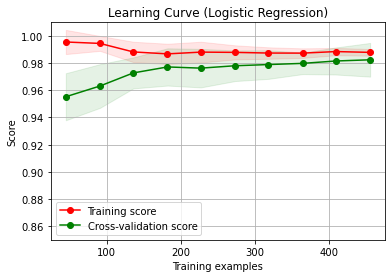

In [10]:
# Determines cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve 
# Random permutation cross-validator 
from sklearn.model_selection import ShuffleSplit
# Logistic regression classifier class
from sklearn.linear_model import LogisticRegression
# kNN classifier class
from sklearn import neighbors
# Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, 
# plots some lines in a plotting area, decorates the plot with labels, etc
import matplotlib.pyplot as plt


title = "Learning Curve (Logistic Regression)"

# Class ShuffleSplit is a random permutation cross-validator
# Parameter n_splits = Number of re-shuffling & splitting iterations
# Parameter test_size = represents the proportion of the dataset to include in the test split (float between 0.0 and 1.0) 
# Parameter random_state = the seed used by the random number generator
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
estimator = LogisticRegression(penalty="l2", C=1, solver="liblinear") # Building LR using optimal parameters from above model
# Plots the learning curve based on the previously defined function for the logistic regression estimator
plot_learning_curve(estimator, title, X_std, y, (0.85, 1.01), cv=cv, n_jobs=4)

plt.show() # Display the figure

In [14]:
#### Fitting curve (aka validation curve)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Encode labels with value between 0 and n_classes-1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#print(y)               #See label before transformation
y = le.fit_transform(y) #Labels 'M' as 1 and 'B' as 0
#print(y)               #See label after transformation
print(le.classes_)      #Show the classes that have been encoded

# Create a decision tree classifier
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=6, min_samples_split=2, random_state=42)

# Evaluate performance
scores=cross_val_score(clf_dt, X=X_std, y=y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print(scores) # print accuracy for each iteration of cross-validation


scores_f1=cross_val_score(clf_dt, X=X_std, y=y, cv=10, scoring='f1_macro')
print("F1-score: %0.2f (+/- %0.2f)" % (scores_f1.mean(), scores_f1.std() * 2))# returns an array of scores of the estimator for each run of the cross validation.
print(scores_f1) # print f1-score for each iteration of cross-validation

[0 1]
Accuracy: 0.92 (+/- 0.10)
[0.94736842 0.84210526 0.92982456 0.84210526 0.94736842 0.92982456
 0.87719298 0.94736842 0.94736842 1.        ]
F1-score: 0.92 (+/- 0.10)
[0.94492754 0.82860007 0.92297297 0.83196856 0.94286669 0.92597403
 0.86668894 0.94286669 0.94398952 1.        ]


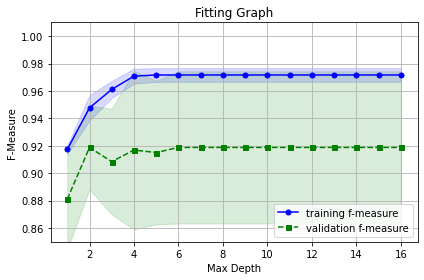

In [17]:
# Determine training and test scores for varying parameter values.
from sklearn.model_selection import validation_curve
# Split validation
from sklearn.model_selection import train_test_split
# Class for Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

np.random.seed(42) #the seed used by the random number generator for np

############################# Parameters - Varying Complexity #############################

# Specify possible parameter values for maximum depth
# More depth equals a more complex model
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


# Determine training and test scores for varying parameter values on our optimal model derived from above
train_scores, test_scores = validation_curve( 
                estimator=DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_leaf=6, 
                                                 min_samples_split=2), 
                X=X_std, 
                y=y, 
                param_name="max_depth", #max depth of a tree
                param_range=param_range,
                cv=10,     #10-fold cross-validation
                scoring="f1_macro", 
                n_jobs=4) # Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”. This parameter is ignored when the ``solver``is set to ‘liblinear’ regardless of whether ‘multi_class’ is specified or not. If given a value of -1, all cores are used.


# Cross validation statistics for training and testing data (mean and standard deviation)
train_mean = np.mean(train_scores, axis=1) # Compute the arithmetic mean along the specified axis.
train_std = np.std(train_scores, axis=1)   # Compute the standard deviation along the specified axis.
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

############################## Visualization - Fitting Graph ##############################

# Plot train accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training f-measure')

# Fill the area around the line to indicate the size of standard deviations of performance for the training data
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

# Plot test accuracy means of cross-validation for all the parameters C in param_range
plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation f-measure')

# Fill the area around the line to indicate the size of standard deviations of performance for the test data
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

# Grid and Axes Titles
plt.grid()
plt.title("Fitting Graph")
plt.legend(loc='lower right')
plt.xlabel('Max Depth')
plt.ylabel('F-Measure')
plt.ylim([0.85, 1.01]) # y limits in the plot
plt.tight_layout()
# plt.savefig('Fitting_graph_LR.png', dpi=300)
plt.show()           # Display the figure

10-fold cross validation:

ROC AUC: 1.00 (+/- 0.00) [Logistic regression]
ROC AUC: 0.96 (+/- 0.03) [Decision tree]
ROC AUC: 0.99 (+/- 0.01) [kNN]


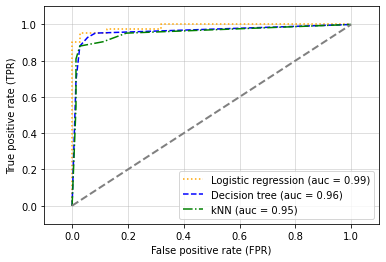

In [64]:
# Importing libraries and packages for ROC and AUC curve evaluation

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Building three different classifier models to evaluate 

# Logistic Regression Classifier
clf1 = LogisticRegression(penalty='l1', 
                          C=1,
                          random_state=42, 
                          solver='liblinear') 

# Decision Tree Classifier
clf2 = DecisionTreeClassifier(max_depth=5,
                              criterion='gini',
                              min_samples_leaf=6,
                              min_samples_split=2,
                              random_state=42)

# kNN Classifier
clf3 = KNeighborsClassifier(n_neighbors=5,
                            weights='uniform',
                            p=2,
                            metric='minkowski')

# Label the classifiers
clf_labels = ['Logistic regression', 'Decision tree', 'kNN']
all_clf = [clf1, clf2, clf3]

#################################### Cross - Validation ####################################


print('10-fold cross validation:\n')
# Note: We are assuming here that the data is standardized. For the homework, you need to make sure the data is standardized.
for clf, label in zip([clf1, clf2, clf3], clf_labels): #For all classifiers 
    scores = cross_val_score(estimator=clf,  #Estimate AUC based on cross validation
                             X=X_std,
                             y=y,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" #Print peformance statistics based on cross-validation
          % (scores.mean(), scores.std(), label))

##################################### Visualization ######################################

colors = [ 'orange', 'blue', 'green']      # Colors for visualization
linestyles = [':', '--', '-.', '-']        # Line styles for visualization
for clf, label, clr, ls in zip(all_clf,
               clf_labels, colors, linestyles):

    # Assuming the label of the positive class is 1 and data is normalized
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1] # Make predictions based on the classifiers
    fpr, tpr, thresholds = roc_curve(y_true=y_test, # Build ROC curve
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)                # Compute Area Under the Curve (AUC) 
    plt.plot(fpr, tpr,                         # Plot ROC Curve and create label with AUC values
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')    # Where to place the legend
plt.plot([0, 1], [0, 1], # Visualize random classifier
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])   #limits for x axis
plt.ylim([-0.1, 1.1])   #limits for y axis
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('ROC_all_classifiers', dpi=300)
plt.show()